# 텍스트 순차열 데이터 분류 Template

# 데이터 준비

In [10]:
import numpy as np
import matplotlib.pyplot as plt


## 기반 문자열 생성

In [11]:
BASE_STRING = "abcde12345"
text_data = BASE_STRING*10
CATEGORY_NUM = 2

In [12]:
SEQUENCE_LENGTH = 5
OFFSET = 1

## 입출력 데이터 생성

'abcde12345abcde12345'의 문자열로 다음의 입출력 데이터를 생성한다.
```
'abcde' -> T
'bcde1' -> F
'cde12' -> T
'de123' -> F
...
'e1234' -> T
```

다음 문자열이 알파벳이면 1, 숫자이면 0을 출력으로 한다.

In [13]:
raw_x = []
raw_y = []

for i in range(len(text_data)):
  if i+SEQUENCE_LENGTH+OFFSET >= len(text_data): break
  raw_x.append(text_data[i:i+SEQUENCE_LENGTH])
  next_ch = text_data[i+SEQUENCE_LENGTH+OFFSET-1]
  raw_y.append([ int(next_ch in 'abcde') ])
#            0         1         2      
#            012345678901234567890123456789
# textdata = abcde12345abcde12345abcde12345
#               i = 3
#               <-x->   = [3:8] = 'de123'
#                    y  = [8]   = '4' is alpahbe = False = 0


In [14]:
print(len(raw_x))
# len(raw_x) = 94 = len(text_data) - SEQUENCE_LENGTH - OFFSET = 100 - 5 - 1

94


## 데이터를 2차원 벡터화 하기

RNN은 2차원 데이터를 입력으로 받는다. 1차원 문자열의 각 문자를 one-hot 인코딩하여 2차원 데이터로 만드렁 준다.<br>
입력 데이터와 출력 데이터를 다음의 형태로 준비한다.<br>
입력 데이터
```
문자열 'abc12'을 인코딩한
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
```




인코딩 디코딩을 위한 유틸 클래스 CharacterTable

In [15]:
class CharacterTable:

    # '1', '2', '3', '4', '5', 'a', 'b', 'c', 'd', 'e'
    #  0    1    2    3    4    5    6    7    8    9 

    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars)) # '+' ->  1
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars)) #  1  -> '+'

    def encode(self, C, num_rows=SEQUENCE_LENGTH):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C): # 각 자리 문자마다
            x[i, self.char_indices[c]] = 1 # 각 줄의 index만 1로 만든다. one-hot encoding한다.
        return x

    def decode(self, x):
        x = x.argmax(axis=-1)
        return "".join(self.indices_char[x] for x in x)


In [16]:
ctable = CharacterTable(BASE_STRING)

다음은 인코딩, 디코딩 예이다.

In [17]:
# 원 문자열
org_str = 'abc12'
print(f"org_str='{org_str}'")

# 인코딩된 값
encoded = ctable.encode(org_str)
# [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]    <==== 'a'
#  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]    <==== 'b'
#  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]    <==== 'c'
#  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]    <==== '1'
#  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]   <==== '2'
print(f"encoded=\n{encoded}")
print(f"encoded.shape={encoded.shape}")

# 다시 디코딩해서 원복한 값
decoded = ctable.decode(encoded)
print(f"decoded='{decoded}'")

org_str='abc12'
encoded=
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
encoded.shape=(5, 10)
decoded='abc12'


In [18]:
print("Vectorization...")

x = np.zeros((len(raw_x), len(raw_x[0]), len(BASE_STRING)), dtype=np.bool)
for i, sentence in enumerate(raw_x):
    x[i] = ctable.encode(sentence)
y = np.array(raw_y).astype(np.int)

print(x.shape)
print(y.shape)

split_at = int(len(x)*0.9)
(train_x, test_x) = x[:split_at], x[split_at:]
(train_y, test_y) = y[:split_at], y[split_at:]

print("Training Data:")
print(train_x.shape)
print(train_y.shape)

print("Test Data:")
print(test_x.shape)
print(test_y.shape)


Vectorization...
(94, 5, 10)
(94, 1)
Training Data:
(84, 5, 10)
(84, 1)
Test Data:
(10, 5, 10)
(10, 1)


준비된 데이터는 다음과 같습니다.

In [19]:
print("train_x[0]\n", train_x[0].astype(np.int))
print()
print("train_y[0]\n", train_y[0].astype(np.int))

train_x[0]
 [[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]

train_y[0]
 [0]


준비된 데이터는 인코딩된 값들입니다. 디코딩에서 본 원 문자열은 다음과 같습니다.

In [20]:
for i in range(10):
  print("'"+ctable.decode(train_x[i])+"' -> "+str(train_y[i][0]))

'abcde' -> 0
'bcde1' -> 0
'cde12' -> 0
'de123' -> 0
'e1234' -> 0
'12345' -> 1
'2345a' -> 1
'345ab' -> 1
'45abc' -> 1
'5abcd' -> 1


# Template

## LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               71168     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 71,426
Trainable params: 71,426
Non-trainable params: 0
_________________________________________________________________


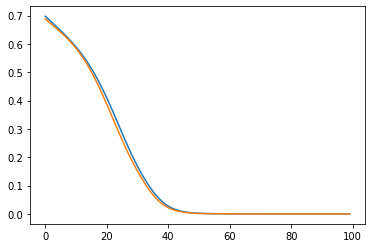

1/1 [==============================] - 0s 16ms/step - loss: 8.1507e-05 - accuracy: 1.0000
loss= 8.150665235007182e-05
acc= 1.0


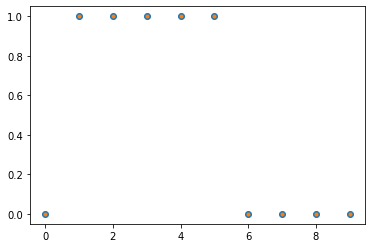

In [21]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(LSTM(128, input_shape=input_shape))
model.add(Flatten())
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y, "o")
plt.plot(predicted, ".")
plt.show()

## GRU

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               53760     
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 54,018
Trainable params: 54,018
Non-trainable params: 0
_________________________________________________________________


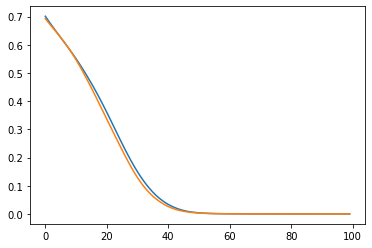

1/1 [==============================] - 0s 14ms/step - loss: 5.2615e-05 - accuracy: 1.0000
loss= 5.26148833159823e-05
acc= 1.0


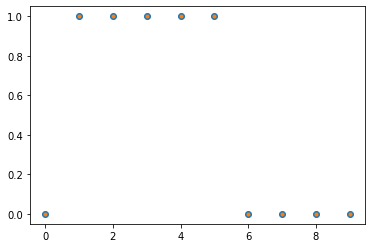

In [22]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(GRU(128, input_shape=input_shape))
model.add(Flatten())
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y, "o")
plt.plot(predicted, ".")
plt.show()

## Bidirectional + LSTM

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               142336    
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 142,850
Trainable params: 142,850
Non-trainable params: 0
_________________________________________________________________


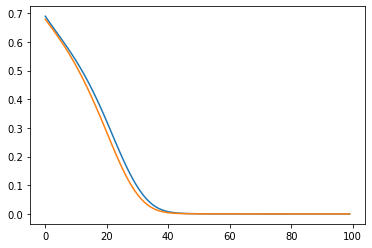

1/1 [==============================] - 0s 14ms/step - loss: 4.6560e-05 - accuracy: 1.0000
loss= 4.6560388000216335e-05
acc= 1.0


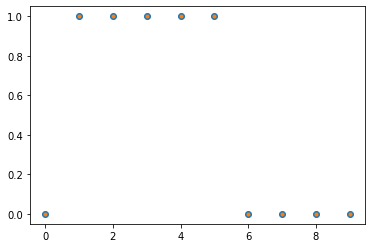

In [23]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(Bidirectional(LSTM(128), input_shape=input_shape))
model.add(Flatten())
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y, "o")
plt.plot(predicted, ".")
plt.show()

## Bidirectional + GRU

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               107520    
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 108,034
Trainable params: 108,034
Non-trainable params: 0
_________________________________________________________________


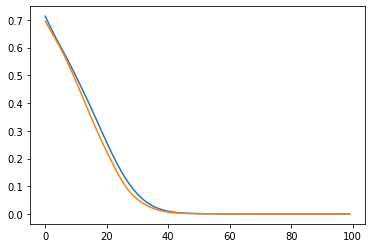

1/1 [==============================] - 0s 15ms/step - loss: 7.0089e-05 - accuracy: 1.0000
loss= 7.008880493231118e-05
acc= 1.0


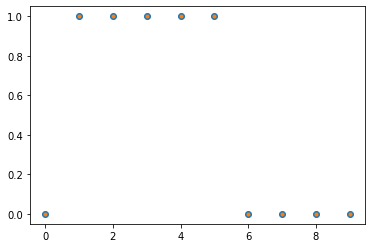

In [24]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(Bidirectional(GRU(128), input_shape=input_shape))
model.add(Flatten())
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y, "o")
plt.plot(predicted, ".")
plt.show()

## stacked

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 128)            71168     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 203,010
Trainable params: 203,010
Non-trainable params: 0
_________________________________________________________________


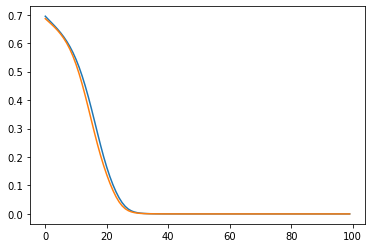

1/1 [==============================] - 0s 15ms/step - loss: 8.2850e-06 - accuracy: 1.0000
loss= 8.284978321171366e-06
acc= 1.0


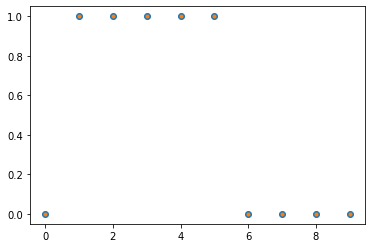

In [25]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y, "o")
plt.plot(predicted, ".")
plt.show()

## CNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 32)             992       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 32)             3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 32)             3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 32)             3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)               

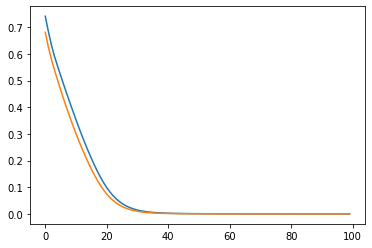

1/1 [==============================] - 0s 22ms/step - loss: 2.9328e-04 - accuracy: 1.0000
loss= 0.00029327557422220707
acc= 1.0


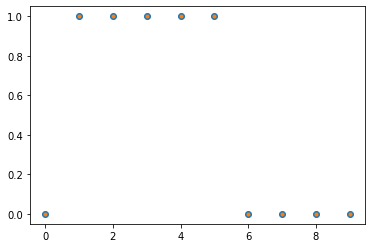

In [26]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Input, Reshape

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(Conv1D(32, 3, padding="same", input_shape=input_shape))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D())
model.add(Conv1D(32, 3, padding="same"))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y, "o")
plt.plot(predicted, ".")
plt.show()

## CNN + LSTM

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 5, 32)             992       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 32)             3104      
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               82432     
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 86,786
Trainable params: 86,786
Non-trainable params: 0
_________________________________________________________________


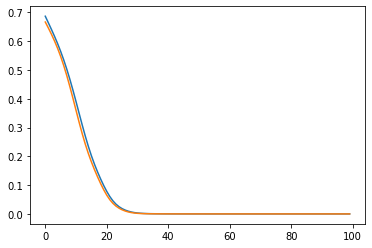

1/1 [==============================] - 0s 15ms/step - loss: 1.8739e-05 - accuracy: 1.0000
loss= 1.8739126971922815e-05
acc= 1.0


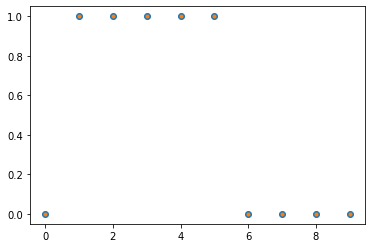

In [27]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Input, Reshape

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(Conv1D(32, 3, padding="same", input_shape=input_shape))
model.add(Conv1D(32, 3, padding="same"))
model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y, "o")
plt.plot(predicted, ".")
plt.show()